In [14]:
import sys
import pythoncyc as pc
import csv
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/stef/Tb/reaction_mapping')
from utils import save_json, load_json

In [38]:
# Settings
filtered_mc_path = '../mapping/mc_v21_as_is.json'
using_jos_rxns = True

# Read in ec numbers saved from mc
rxns_wo_ec = []
with open('mc_wo_ec.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
            rxns_wo_ec.append(row[0])

rxns_w_ec = load_json('mc_ec.json')

print(len(list(rxns_w_ec.keys())) / (len(list(rxns_w_ec.keys())) + len(rxns_wo_ec)))

# Modify ec lists with reversed reaction ids
filtered_mc_rxns = load_json(filtered_mc_path)
filtered_rxns_w_ec = {}
filtered_rxns_wo_ec = []

if using_jos_rxns:
    for k,v in filtered_mc_rxns.items():
        if '|' + k.rstrip('_reverse') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif '|' + k.rstrip('_reverse') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec['|' + k.rstrip('_reverse') + '|']
else:
    for k,v in filtered_mc_rxns.items():
        if k.rstrip('_REV|') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif k.rstrip('_REV|') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec[k.rstrip('_REV|') + '|']

print(len(list(filtered_rxns_w_ec.keys())) / len(filtered_mc_rxns))

0.7913456141246109
0.8429842076601924


In [16]:
# Load in all rule names
rules_path = '../mapping/JN3604IMT_rules.tsv'
all_rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        all_rules.append(row[0])

all_rules = all_rules[1:]

In [41]:
# Load mapping
mapping_path = '../mapping/mapping_all_mc_v21_imt_rules.csv'
missing_path = '../mapping/missing_smiles_all_mc_v21_imt_rules.csv'
parse_path = '../mapping/smiles_parse_issues_all_mc_v21_imt_rules.csv'
all_rxns = []
mapped_rxns = []
unmapped_rxns = []
missing_smiles = []
parse_issues  = []
rxn2rule = {}

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
            rxn2rule[row[0]] = []
        else:
            mapped_rxns.append(row[0])
            rxn2rule[row[0]] = row[1:]

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

all_rxns = list(set(all_rxns) - set(missing_smiles))
all_rxns = list(set(all_rxns) - set(parse_issues))
unmapped_rxns = list(set(unmapped_rxns) - set(missing_smiles))
unmapped_rxns = list(set(unmapped_rxns) - set(parse_issues))

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))

Mapping fraction: 0.6725700164744646
Total # reactions analyzed: 21852


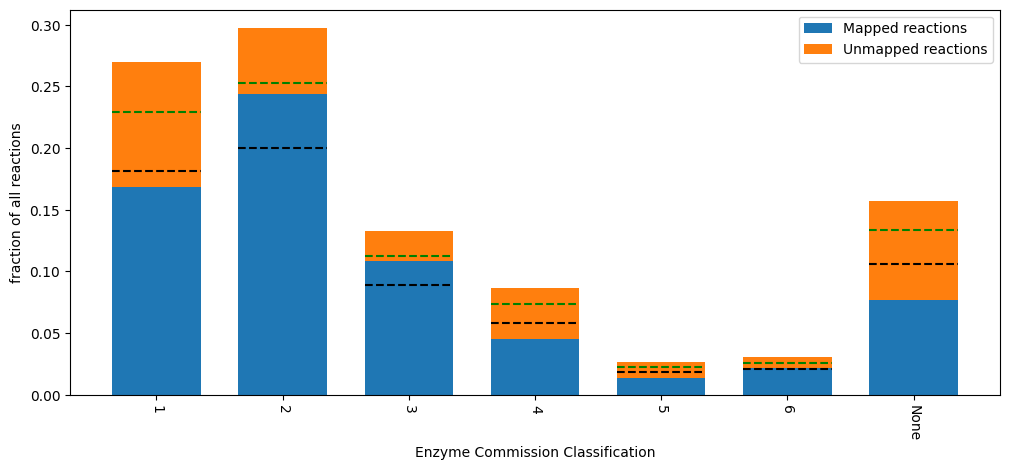

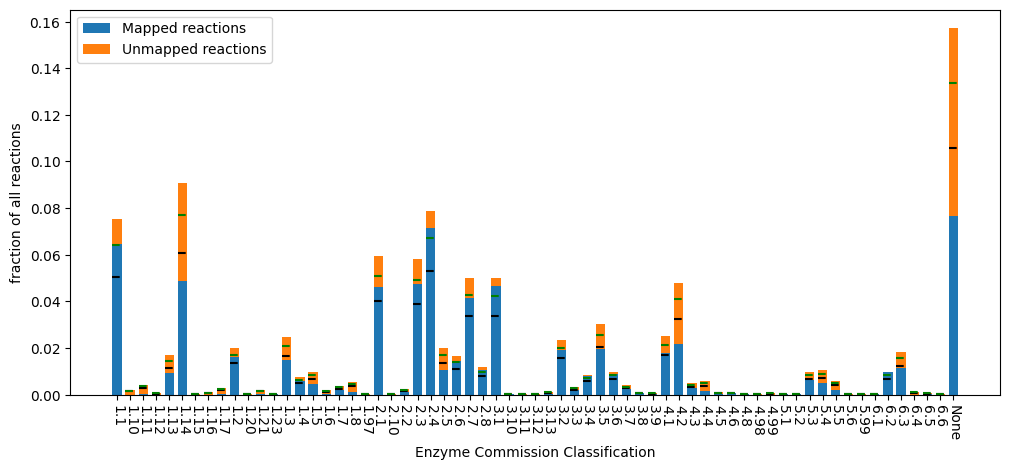

In [44]:
map_frac = len(mapped_rxns) / len(all_rxns)

# Counts by EC. Sublists correspond mapped, unmapped
# dicts from left to right are 1st digit, 2nd digit ec
# keys in dicts are ec #
ecc_arrs = [[{}, {}], [{}, {}]]
ec_to_rxn = [[{}, {}], [{}, {}]] # Same structure as ecc_arrs but tracks rxn ids, not counts
for i, arr in enumerate([mapped_rxns, unmapped_rxns]): # Iterate over mapped, unmapped lists
    for elt in arr: # Iterate over rxn ids in both lists

        if elt in filtered_rxns_w_ec.keys():
            this_ecc = filtered_rxns_w_ec[elt]
            this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|').split('.')
            ecc1 = this_ecc[0]
            if ecc1 != '7': # Catch a few remaining tranport reactions

                # Catch entries with 1st but not
                # second digit ec... kludgy but ok for now
                if len(this_ecc) > 1:
                    ecc2 = ecc1 + '.' + this_ecc[1]
                else:
                    ecc2 = 'None'

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                    ec_to_rxn[i][0][ecc1] = [elt]
                else:
                    ecc_arrs[i][0][ecc1] += 1
                    ec_to_rxn[i][0][ecc1].append(elt)

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                    ec_to_rxn[i][1][ecc2] = [elt]
                else:
                    ecc_arrs[i][1][ecc2] += 1
                    ec_to_rxn[i][1][ecc2].append(elt)
        else:
            if 'None' not in ecc_arrs[i][0]:
                ecc_arrs[i][0]['None'] = 1
                ec_to_rxn[i][0]['None'] = [elt]
            else:
                ecc_arrs[i][0]['None'] += 1
                ec_to_rxn[i][0]['None'].append(elt)

            if 'None' not in ecc_arrs[i][1]:
                ecc_arrs[i][1]['None'] = 1
                ec_to_rxn[i][1]['None'] = [elt]
            else:
                ecc_arrs[i][1]['None'] += 1
                ec_to_rxn[i][1]['None'].append(elt)

ec_1st_union = list(set(ecc_arrs[0][0].keys()) | set(ecc_arrs[1][0].keys()))
ec_2nd_union = list(set(ecc_arrs[0][1].keys()) | set(ecc_arrs[1][1].keys()))
for elt in ecc_arrs:
    for k in ec_1st_union:
        if k not in elt[0].keys():
            elt[0][k] = 0

    for k in ec_2nd_union:
        if k not in elt[1].keys():
            elt[1][k] = 0


# Make two plots
labels = ['Mapped reactions', 'Unmapped reactions']
width = 0.7
ymax = [0.55, 0.35]
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    tot = sum(list(ecc_arrs[0][i].values())) + sum(list(ecc_arrs[1][i].values()))
    

    for j in range(2): # Iterate over mapped, unmapped
        xs = np.arange(len(ecc_arrs[j][i]))
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 0:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_names = names
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
            ax.set_xticklabels(names, rotation=-90)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * map_frac, x - width / 2, x + width / 2, color='k', ls='--')
        ax.hlines(top * 0.85, x - width / 2, x + width / 2, color='g', ls='--')
    
    # ax.set_ylim(0, ymax[i])
    ax.set_xlabel(f"Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()

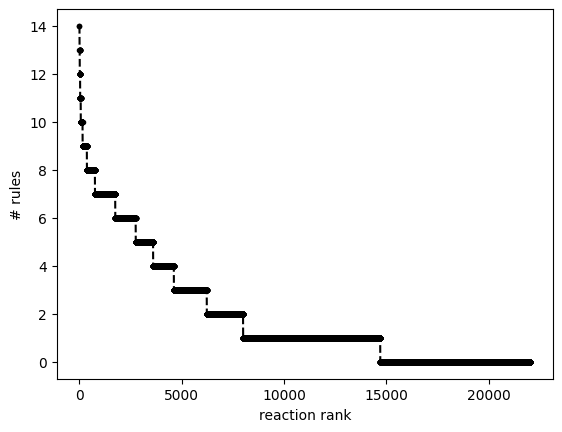

In [45]:
# Plot rule counts by reaction (on most specific level available)
n_rules_per_rxn = sorted([len(elt) for elt in rxn2rule.values()], reverse=True)
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(n_rules_per_rxn) + 1), n_rules_per_rxn, 'k.--')
ax.set_xlabel('reaction rank')
ax.set_ylabel('# rules')
plt.show()

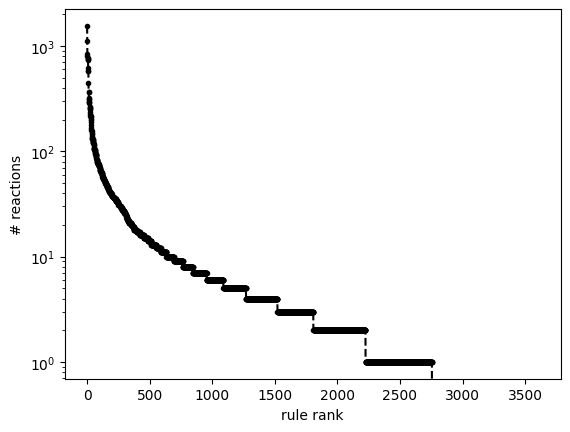

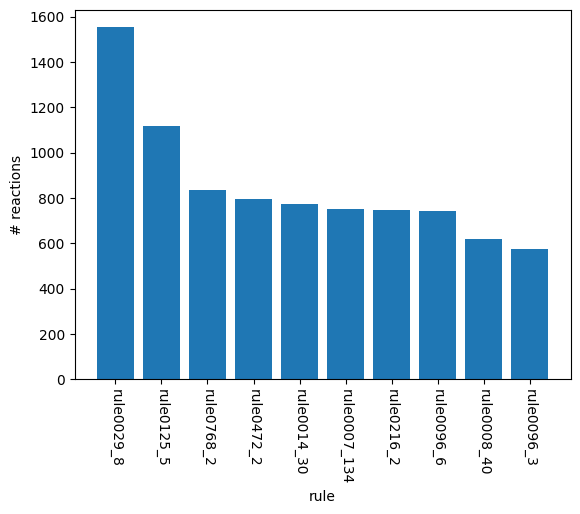

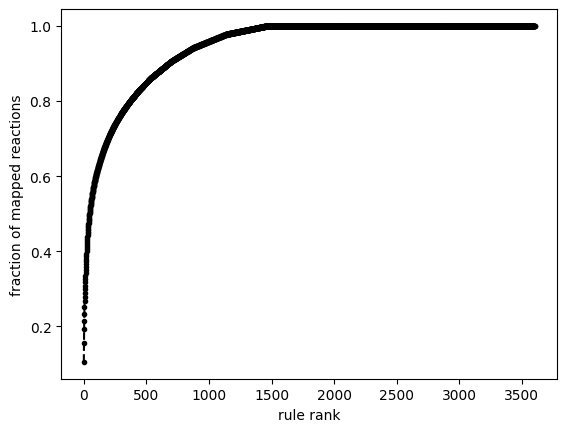

370


In [46]:
# Plot reaction counts by rule
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Order rules by those that contribute the maximum
# number of "new" reactions to the mapping pool as possible
mapping_pool = set()
max_delta_sorted = [] # Reactions sorted by contribution to the mapping pool
deltas = []
search_space = all_rules.copy()

# Go until you've gotten all the rules
while len(max_delta_sorted) < len(all_rules):
    best_contribution = set()
    best_delta = 0
    # Iterate over search space to find max contribution
    for elt in search_space:
        if elt in rule2rxn.keys():
            this_rxns = set(rule2rxn[elt])
        else:
            this_rxns = set()

        this_contribution = this_rxns - mapping_pool # In this rxns but not pool
        this_delta = len(this_contribution)
        if this_delta >= best_delta:
            best_contribution = this_contribution
            best_delta = this_delta
            best_id = elt

    # Update pool
    mapping_pool = mapping_pool | best_contribution
    deltas.append(best_delta)
    max_delta_sorted.append(best_id)
    search_space.remove(best_id) # Reduce search space by the rule you got

rxn_ct_cdf = np.cumsum(deltas) / len(mapped_rxns)
eighty_percent = np.where(np.array(rxn_ct_cdf) > 0.8)[0][0]

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), rxn_cts[:n], tick_label=rules[:n])
ax.set_xticklabels(rules[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

# Plot cumulative distr
fig, ax = plt.subplots()
ax.plot(rxn_ct_cdf, 'k.--')
ax.set_xlabel('rule rank')
ax.set_ylabel('fraction of mapped reactions')
plt.show()
print(eighty_percent)

In [47]:
# Intermediate rules only!
# Re-do rule cts by reaction with general
# rule ids

# Make dict with rule cts per reaction
# described only by the general rule id
gen_imt_rxn_by_rule = np.zeros(shape=(len(all_rxns), len(all_rules)))

for i,id in enumerate(all_rxns):
    this_rxn_rules = rxn2rule[id]
    this_ct = [0 for j in range(len(all_rules))]
    for elt in this_rxn_rules:
        idx = int(elt.lstrip('rule').split('_')[0])
        this_ct[idx] += 1
    gen_imt_rxn_by_rule[i,:] = this_ct
    
rxn_idxs, rule_idxs = np.where(gen_imt_rxn_by_rule > 1)
print(len(rxn_idxs))

1573


In [52]:
# Load josephs original reaction data w/ mapping assignments
jos_rxns = load_json('../jos_rxn_data/metacyc.json')
id1 = 'RXN-12199'
id2 = 'RXN-7830'
jos_rxns[id1][-1], jos_rxns[id2][-1]

('Unmapped', 'rule0001')

In [55]:
rxn2rule[id1], rxn2rule[id2]

([],
 ['rule0001_13',
  'rule0006_110',
  'rule0007_152',
  'rule0009_16',
  'rule0096_3',
  'rule0097_2'])

In [61]:
# Jos mapfrac
jos_mapped = {}
for elt in all_rxns:
    if jos_rxns[elt][-1] != 'Unmapped':
        jos_mapped[elt] = jos_rxns[elt][-1]

print(len(jos_mapped) / len(all_rxns))

# Get reactions that jos mapped but I missed
missed = []
for elt in all_rxns:
    if (len(rxn2rule[elt]) == 0) & (jos_rxns[elt][-1] != 'Unmapped'):
        missed.append(elt)

len(missed)

0.8334706205381659


3970

In [64]:
jos_rxns[missed[0]]

[{'3-METHYLBENZYLSUCCINATE:0': 'Cc1cccc(CC(CC(=O)O)C(=O)O)c1'},
 {'FUM:0': 'O=C(O)/C=C/C(=O)O', 'META-XYLENE:0': 'Cc1cccc(C)c1'},
 'Q8VPT6,Q8VPT7',
 'rule0306']

In [65]:
filtered_mc_rxns[missed[0]]

[{'3-METHYLBENZYLSUCCINATE:0': 'Cc1cccc(CC(CC(=O)O)C(=O)O)c1'},
 {'FUM:0': 'O=C(O)/C=C/C(=O)O', 'META-XYLENE:0': 'Cc1cccc(C)c1'}]

In [60]:
len(all_rxns), len(jos_rxns)

(21852, 22036)

False